# 2D bounding boxes using instance segmentation

## 1. Cloning repository to get images

In [2]:
%%capture
! git clone https://github.com/kar-ab/Labelling_utilities

In [3]:

# # # import libraries
import glob
import os

# # load images from image_02 folder (left rectified RGB images)
rgb_files = sorted(glob.glob(
    "/content/Labelling_utilities/kitti_dataset/rgb/*.png"))
print( len(rgb_files), 'left rectified RGB images are loaded')

# # load images from image_02 folder (left rectified RGB images)
instance_files = sorted(glob.glob(
    "/content/Labelling_utilities/kitti_dataset/instance/*.png"))
print( len(instance_files), 'left instance labelled RGB images are loaded')

2 left rectified RGB images are loaded
2 left instance labelled RGB images are loaded


## 2. Annotating Images using instance segmentation

Filtered Bounding Boxes:  4


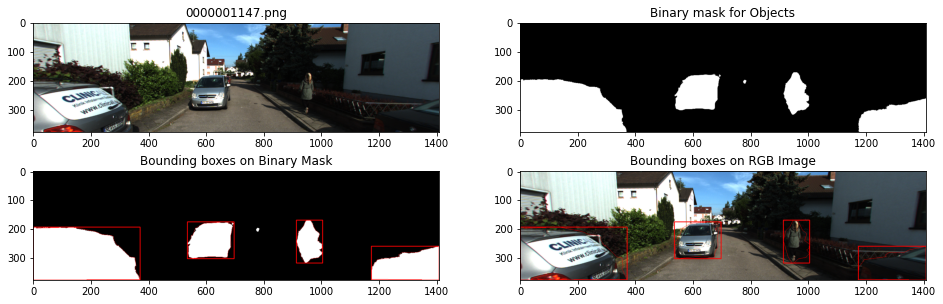

In [4]:
from __future__ import print_function

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random as rng
import glob
import os

def annotate(rgb, ins_img, min_wd_bounding_box, min_ht_bounding_box):
    
    rgb_imge = rgb.copy()

    object_mask = np.zeros_like(ins_img)
    # instances of cars
    object_mask = np.where( 
        np.logical_and (ins_img >= 100, ins_img < 111) , 255, object_mask ) 
    # instances of pedestrians
    object_mask = np.where( 
        np.logical_and (ins_img >= 90, ins_img < 100) , 255, object_mask )
    object_mask_binary = object_mask

    object_mask_binary = np.uint8(object_mask_binary,)

    src = cv2.blur(object_mask_binary, (3,3))

    # Bounding boxes using sem_seg images and contours
    # https://docs.opencv.org/3.4/da/d0c/tutorial_bounding_rects_circles.htm
    
    # without canny to reduce double count
    contours,_ = cv2.findContours(src[:,:,0],
                                  cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contours_poly = [None]*len(contours)
    boundRect = [None]*len(contours)

    for i, c in enumerate(contours):
        contours_poly[i] = cv2.approxPolyDP(c, 3, True)
        boundRect[i] = cv2.boundingRect(contours_poly[i])
    
    bin_bb = np.zeros((src.shape[0],\
                        src.shape[1], 3), dtype=np.uint8)

    bin_bb = object_mask_binary.copy()
    filtered_boundRect = []
    for i in range(len(contours)):

        if ( int(boundRect[i][3]) > min_ht_bounding_box and 
            int(boundRect[i][2]) > min_wd_bounding_box ): 
            filtered_boundRect.append(boundRect[i])
            x1 = int(boundRect[i][0]) # start_x
            y1 = int(boundRect[i][1]) # start_y
            x2 = int( boundRect[i][0] + boundRect[i][2]) # end_x
            y2 = int(boundRect[i][1] + boundRect[i][3] ) # end_y
            # width of bbox = boundRect[i][2]
            # height of bbox =  boundRect[i][3] 
            
            color = (255, 0, 0)                       
            # bb on binary map
            cv2.drawContours(bin_bb, contours_poly, i, color)
            cv2.rectangle(bin_bb, ( x1, y1), ( x2, y2), color, 2)
            # bb on rgb image map
            cv2.drawContours(rgb_imge, contours_poly, i, color)
            cv2.rectangle(rgb_imge, ( x1, y1), ( x2, y2), color, 2)
            
            # print('center_x:', ((x1 + boundRect[i][2]*0.5)/cv_image.shape[1]),
            #  'center_y:', (y1 + boundRect[i][3]*0.5)/cv_image.shape[0])
    return  object_mask_binary, bin_bb, rgb_imge, boundRect, filtered_boundRect


min_ht_bounding_box = 15
min_wd_bounding_box = 15

'''
result tuple: 
pole_mask, bb_rgb, bb_binary, boundRect, filtered_boundRect
'''

index = 0
img_ins = cv2.cvtColor(cv2.imread(instance_files[index]), cv2.COLOR_BGR2RGB ) 
img = cv2.cvtColor(cv2.imread(rgb_files[index]), cv2.COLOR_BGR2RGB ) 

result = annotate( img, img_ins, min_wd_bounding_box, min_ht_bounding_box)

fig, axarr = plt.subplots(2,2,figsize=(16,5))
# Input Image
axarr[0, 0].imshow(img)
axarr[0, 0].set_title(rgb_files[index][-14:])
# Semantic Segmentation 
axarr[0, 1].imshow(result[0])
axarr[0, 1].set_title('Binary mask for Objects')
# Mask for Pole like Objects
axarr[1,0].imshow(result[1])
axarr[1, 0].set_title('Bounding boxes on Binary Mask')
# Bounding Box outputs
axarr[1,1].imshow(result[2])
axarr[1, 1].set_title('Bounding boxes on RGB Image')
# print('Proposed Bounding Boxes: ', len(result[3]))
print('Filtered Bounding Boxes: ', len(result[4]))